In [1]:
import sys  
sys.path.insert(0, './machine_learning_models')

from logistic_regression import logistic_regression
from stochastic_gradient_descent import stochastic_gradient_descent
from knn import knn
from kernel_svm import kernel_svm
from naive_bayes import naive_bayes
from random_forest import random_forest
from voting_classifier import voting_classifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output
from itertools import product, combinations
import json

In [19]:
league_id = 71 # Choose the league id

season_file = '2008-2021'

first_season = 2008
last_season = 2021

min_threshold = 1.75
max_threshold = 4

num_model_combinations = 1

# default_stake = 50
bankroll = 2000
stake = 0.025

In [20]:
print('\nGetting data for the model...')

season = "{}-{}".format(first_season, last_season)

default_path = f'./leagues/{league_id}'
whole_dataset = pd.read_csv('./data/{}.csv'.format(season_file))
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date

X = whole_dataset.iloc[:, 7:-1].values
y = whole_dataset.iloc[:, -1].values


Getting data for the model...


In [21]:
whole_dataset.tail()

,Unnamed: 0,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,...,FT_PCT_B,REB_B,TOV_B,SEASON_B_PCT,PER_B,ELO_B,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,WINNER
14464,14464,2021,2022-04-10,NYK,TOR,1.96,1.89,110.1,106.6,0.4482,...,0.8010,45.1,11.4,0.592593,15.541340,1603.60,0.8,0.426210,-3,H
14465,14465,2021,2022-04-10,ORL,MIA,3.39,1.35,100.5,110.4,0.4216,...,0.8112,38.5,15.3,0.654321,27.693215,1626.31,0.8,0.466592,-6,H
14466,14466,2021,2022-04-10,PHI,DET,1.37,3.23,119.6,113.5,0.4942,...,0.8478,43.1,13.0,0.283951,15.774737,1382.53,0.2,0.389988,-2,H
14467,14467,2021,2022-04-10,PHX,SAC,1.19,5.14,116.4,114.4,0.4900,...,0.7755,40.8,13.9,0.358025,15.034677,1363.80,0.4,0.334146,-3,A
14468,14468,2021,2022-04-10,POR,UTA,10.90,1.06,100.7,122.0,0.4357,...,0.7139,43.7,12.3,0.592593,14.167984,1571.03,0.7,0.413349,-1,A


In [37]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    
    path = 'charts'
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.savefig(f"{path}/{title.replace(' ','_').lower()}.png", dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    try:
        data_converted = np.unique(data, return_counts=True)[1]
        plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
        plt.title(title)
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show() 
    except Exception as e:
        print(f'Error when trying to plot the pie chart: {e}')

def check_bet_worth(prediction, odds_home, odds_away, pred_odds_home, pred_odds_away):
    return ((prediction == 'H' and (pred_odds_home < odds_home) and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (pred_odds_away < odds_away) and (odds_away > min_threshold and odds_away < max_threshold)))

def check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away):
    game_money = 0
    
    if check_bet_worth(prediction, game['ODDS_A'], game['ODDS_B'], pred_odds_home, pred_odds_away):
        if game['WINNER'] == prediction and game['WINNER'] == 'H':
            game_money = (bet_value*game['ODDS_A'] - bet_value)
        elif game['WINNER'] == prediction and game['WINNER'] == 'A':
            game_money = (bet_value*game['ODDS_B'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

def check_game_with_odds(game, bet_value, pred_odds_home, pred_odds_away):
    
    prediction = 'A'
    if game['ODDS_A'] > game['ODDS_B']:
        prediction = 'H'
    
    return check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away)

def get_bet_value(bankroll):
    bankroll_baseline = round(bankroll / 1000, 0) * 1000
    return stake * bankroll_baseline
#     return default_stake

def get_pred_odds(probs):
    return 1/probs[0], 1/probs[1] # Away, Home

In [23]:
def get_feature_correlation_matrix(dataset):
    print('\nGetting the feature correlation matrix...')

    import seaborn as sns

    try:
        dependent_variables = dataset.iloc[:,9:]
        corrmat = dependent_variables.corr()
        top_corr_features = corrmat.index
        plt.figure(figsize=(13,13))
        title = 'Feature Correlation'
        plt.title(title)
        #plot heat map
        sns.set(font_scale=0.6)
        g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show()
    except:
        print('No correlation matrix for the selected model.')

In [24]:
def train_lr_model(dataset):
    logisticRegression = logistic_regression(dataset)
    return logisticRegression[2]

def train_sgd_model(dataset):
    sgd = stochastic_gradient_descent(dataset)
    return sgd[2]

def train_knn_model(dataset):
    knn_model = knn(dataset)
    return knn_model[2]

def train_svm_model(dataset):
    svm = kernel_svm(dataset)
    return svm[2]

def train_nb_model(dataset):
    nb = naive_bayes(dataset)
    return nb[2]

def train_rf_model(dataset):
    rf = random_forest(dataset)
    return rf[2]

def get_models_names(indexes):
    models = [
        'Logistic Regression',
        'Kernel SVM',
        'Naive Bayes',
        'Stochastic Gradient Descent',
        'K Nearest Neighbors',
        'Random Forest'
    ]
    
    return [models[i] for i in range(len(models)) if i in indexes]

def train_voting_model(dataset, indexes):
    estimators = []
    
    if 0 in indexes: estimators.append(('lr', train_lr_model(dataset)))
    if 1 in indexes: estimators.append(('svm', train_svm_model(dataset))) 
    if 2 in indexes: estimators.append(('nb', train_nb_model(dataset))) 
    if 3 in indexes: estimators.append(('sgd', train_sgd_model(dataset)))
    if 4 in indexes: estimators.append(('knn', train_knn_model(dataset)))
    if 5 in indexes: estimators.append(('rf', train_rf_model(dataset)))

    weights = [1] * len(estimators)
    
    vc = voting_classifier(dataset, estimators, weights)
    return vc[2]


In [34]:
def print_bankroll_update(result, models, seasons):
    print('\nProfit and margin by model...')
    won = result['total_bankroll'] - bankroll
    print('Seasons: {} \t// Models: {} \t// Bankroll: {} \t// Won: {:.2f} \t// Margin: {:.2f}%'.format(seasons, models, round(result['total_bankroll'], 2), won, 100*won/bankroll))

In [26]:
def simulate_by_model(dataset, dataset_itr, model_indexes, combination_progress):
    models = get_models_names(model_indexes)
    
    money_by_date = []
    bets = []
    money_by_team = dict()
    total_invested = 0
    parlay_model = {
        'parlay_odds': 0,
        'parlay_won': True,
        'parlay_matches': []
    }
    outcome_predictions = {'H': 0, 'A': 0}

    money_by_date.append({
        'date': dataset_itr.iloc[0,2],
        'date_profit': 0,
        'total_bankroll': bankroll
    })

    for index, game in dataset_itr.iterrows():
        clear_output(wait=True)

        print(combination_progress)
        print(f"Current test for models {models}: {index}/{len(dataset_itr.index)}")

        # Next date
        if game['GAME_DATE'] != money_by_date[-1]['date']:    
            # Tracking built parlay
            if parlay_model['parlay_odds'] >= 1.5:
                bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])
                game_money_model = ((parlay_model['parlay_odds'] * bet_value) - bet_value) if parlay_model['parlay_won'] else -bet_value
                total_invested += bet_value
                money_by_date[-1]['date_profit'] += game_money_model
                money_by_date[-1]['total_bankroll'] += game_money_model
                
#                 print('\nPARLAY LIST:')
#                 print(f"ODDS: {parlay_model[model][0]} \nMATCHES: {parlay_model[model][2]}\n")

            parlay_model = {
                'parlay_odds': 0,
                'parlay_won': True,
                'parlay_matches': []
            }
            money_by_date.append({
                'date': game['GAME_DATE'],
                'date_profit': 0,
                'total_bankroll': money_by_date[-1]['total_bankroll']
            })

        if game['TEAM_A'] not in money_by_team:
            money_by_team[game['TEAM_A']] = 0
        if game['TEAM_B'] not in money_by_team:
            money_by_team[game['TEAM_B']] = 0

        dataset_train = dataset.loc[(dataset['GAME_DATE'] < game['GAME_DATE'])]
        X_train = dataset_train.iloc[:, 7:-1].values
        from sklearn.preprocessing import StandardScaler
        sc_train = StandardScaler()
        sc_train.fit(X_train)
        game_parameters = game.iloc[7:-1]
        X_transformed = sc_train.transform([game_parameters])

        classifier = train_voting_model(dataset_train, model_indexes)

        game_money_model = 0
        bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])

        prediction = classifier.predict(X_transformed)[0]
        probs = classifier.predict_proba(X_transformed)[0]

        if probs[0] == 1 or probs[0] == 0:
            continue

        pred_odds_away, pred_odds_home = get_pred_odds(probs)
        game_money_model = check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away)

        if game_money_model != 0:       
            if game['WINNER'] == prediction and game['WINNER'] == 'H':
                bets.append(['HOME', game['ODDS_A'], pred_odds_home, 1])
                money_by_team[game['TEAM_A']] += game_money_model
            elif game['WINNER'] == prediction and game['WINNER'] == 'A':
                bets.append(['AWAY', game['ODDS_B'], pred_odds_away, 1])
                money_by_team[game['TEAM_B']] += game_money_model
            else:
                if prediction == 'H':
                    bets.append(['HOME', game['ODDS_A'], pred_odds_home, 0])
                    money_by_team[game['TEAM_A']] += game_money_model
                else:
                    bets.append(['AWAY', game['ODDS_B'], pred_odds_away, 0])
                    money_by_team[game['TEAM_B']] += game_money_model

            total_invested += bet_value
        else:
            odds = game['ODDS_A'] if prediction == 'H' else game['ODDS_B']
            parlay_model['parlay_odds'] = odds * parlay_model['parlay_odds'] if parlay_model['parlay_odds'] > 0 else odds # Parlay odds
            parlay_model['parlay_matches'].append(f"{game['TEAM_A']} ({game['ODDS_A']}) x ({game['ODDS_B']}) {game['TEAM_B']}") # Parlay match counter
            
        if game_money_model == 0 and prediction != game['WINNER']:
            parlay_model['parlay_won'] = False 

        outcome_predictions[prediction] += 1

#         print(f"\nGAME DATE: {game['GAME_DATE']}")
#         print(f"GAME OUTCOME: {game['OUTCOME']}")
#         print(f"PREDICTED OUTCOME: {prediction}")
#         print(f"GAME: {game['HOME_TEAM']} ({game['HOME_ODDS']}) x ({game['AWAY_ODDS']}) {game['AWAY_TEAM']}")

        money_by_date[-1]['date_profit'] += game_money_model
        money_by_date[-1]['total_bankroll'] += game_money_model
        
    return {
        'models': models,
        'results': money_by_date,
        'outcome_distribution': outcome_predictions,
        'bets': bets,
        'profit_by_team': money_by_team,
        'total_invested': total_invested
    }


In [27]:
def save_league_season_results(results, season_train, season_test):
    path = f"results/{num_model_combinations}-models"
    file_name = f"{season_train}-{season_test}.json"

    if not os.path.exists(path):
        os.makedirs(path)

    with open(f"{path}/{file_name}", 'w') as f:
        json.dump(results, f, indent = 4, sort_keys = True, default = str)

In [28]:
def simulate(season_train, season_test):
    print(f"\Simultating the results for season {season_test}...")
    
    dataset = whole_dataset.loc[(whole_dataset['SEASON_ID'] >= season_train) & (whole_dataset['SEASON_ID'] <= season_test)].reset_index(drop=True)
    dataset_itr = dataset.loc[dataset['SEASON_ID'] == season_test].reset_index(drop=True)
    # dataset_filtered = dataset.loc[dataset['GAME_DATE'] > dt.date(2022, 8, 25)]
    
    models = list(range(5))
    model_combinations = list(set(list(combinations(models, num_model_combinations))))
    
    season_results = []
    
    for i in range(len(model_combinations)):
        result = simulate_by_model(dataset, dataset_itr, model_combinations[i], f"Season {season_test}/{last_season} \nModel Combination {i+1}/{len(model_combinations)}")
        result['seasons'] = f"{season_train}-{season_test}"
        season_results.append(result)
        
    save_league_season_results(season_results, season_train, season_test)
        
    return season_results


In [29]:
results = []
for season in range(first_season, last_season):
    results.extend(simulate(season, season+1))

Season 2021/2021 
Model Combination 5/5
Current test for models ['Stochastic Gradient Descent']: 1072/1073


In [35]:
results.sort(key=lambda x: x['results'][-1]['total_bankroll'], reverse=True)
[print_bankroll_update(r['results'][-1], r['models'], r['seasons']) for r in results]


Profit and margin by model...
Seasons: 2017-2018 	// Models: ['K Nearest Neighbors'] 	// Bankroll: 3838.0 	// Won: 1838.00 	// Margin: 91.90%

Profit and margin by model...
Seasons: 2017-2018 	// Models: ['Kernel SVM'] 	// Bankroll: 2452.23 	// Won: 452.23 	// Margin: 22.61%

Profit and margin by model...
Seasons: 2020-2021 	// Models: ['Stochastic Gradient Descent'] 	// Bankroll: 1985.6 	// Won: -14.40 	// Margin: -0.72%

Profit and margin by model...
Seasons: 2014-2015 	// Models: ['Naive Bayes'] 	// Bankroll: 1953.36 	// Won: -46.64 	// Margin: -2.33%

Profit and margin by model...
Seasons: 2020-2021 	// Models: ['Logistic Regression'] 	// Bankroll: 1930.64 	// Won: -69.36 	// Margin: -3.47%

Profit and margin by model...
Seasons: 2009-2010 	// Models: ['Kernel SVM'] 	// Bankroll: 1688.64 	// Won: -311.36 	// Margin: -15.57%

Profit and margin by model...
Seasons: 2019-2020 	// Models: ['Logistic Regression'] 	// Bankroll: 1617.19 	// Won: -382.81 	// Margin: -19.14%

Profit and ma

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [31]:
print(results[0]['outcome_distribution'])

{'H': 654, 'A': 386}


In [32]:
print('\nPlotting charts...')

models_tracking =  [np.array([x['total_bankroll'] for x in results[0]['results']], dtype=np.float32)]

money_by_date = np.array([[r['date'], r['total_bankroll']] for r in results[0]['results']], dtype=str)
correct_bets = list(filter(lambda x: x[3] == 1, results[0]['bets']))
missed_bets = list(filter(lambda x: x[3] == 0, results[0]['bets']))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(results[0]['profit_by_team'].items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


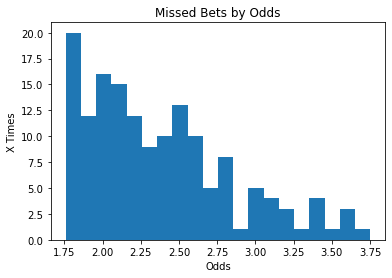

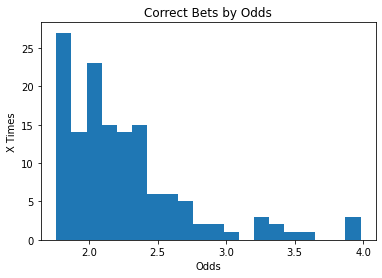

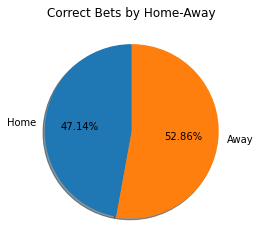

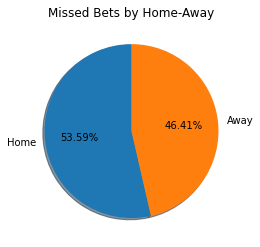

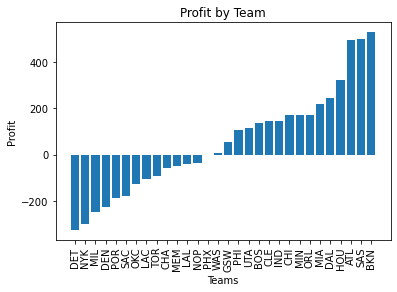

In [38]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

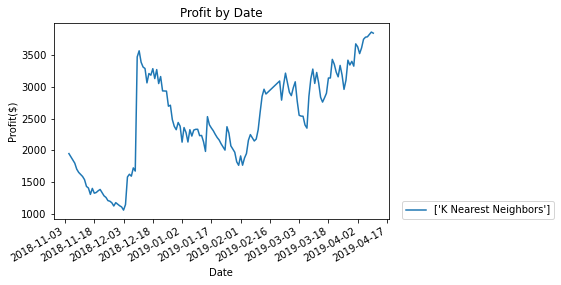

In [39]:
xpoints = money_by_date[:, 0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)

title = "Profit by Date"
plt.legend([results[0]['models']], loc=(1.04,0))
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()